In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_91246/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_sherbrooke') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_brisbane') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_nazca') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_kyoto') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_osaka') from IBMQ(hub='ibm-q-nus', group='default', project='default')>]

In [3]:
job_1 = provider.backend.retrieve_job('cpe5ntzbtqp0008fygb0')
job_2 = provider.backend.retrieve_job('cpe5nyfyx18g008bhtqg')

In [4]:
from utils import *

ns = 1e-9

tau_1_est = 45 * ns
tau_1_span = 4 * ns
num_tau_1 = 2

tau_1_linspace = np.linspace(-0.5 * tau_1_span + tau_1_est, 0.5 * tau_1_span + tau_1_est, num_tau_1)
real_tau_1_linspace = convert_arr_to_dt(tau_1_linspace)

print(tau_1_linspace/ns)
print(real_tau_1_linspace/ns)

[43. 47.]
[42.66666667 46.22222222]


In [5]:
dt = 1/4.5 * ns

tau_readout = get_dt_from(270 * ns) * dt
tau_3 = get_dt_from(42 * ns) * dt
print(tau_readout/ns)
print(tau_3/ns)

acq_duration_dt = 48
acq_latency_dt = get_dt_from(320 * ns)
acq_start = 0. * ns
acq_end = 750 * ns
num_acq_exp = 98
acq_linspace = np.linspace(acq_start, acq_end, num_acq_exp)
real_acq_linspace = convert_arr_to_dt(acq_linspace)
diff = np.diff(real_acq_linspace)
print(diff/ns)
print(real_acq_linspace/ns)
print(f"Total Exps: {(num_tau_1 + 1) * num_acq_exp * 2}")

270.22222222222223
42.666666666666664
[ 7.11111111  7.11111111 10.66666667  7.11111111  7.11111111  7.11111111
  7.11111111  7.11111111 10.66666667  7.11111111  7.11111111  7.11111111
  7.11111111  7.11111111 10.66666667  7.11111111  7.11111111  7.11111111
  7.11111111  7.11111111 10.66666667  7.11111111  7.11111111  7.11111111
  7.11111111 10.66666667  7.11111111  7.11111111  7.11111111  7.11111111
  7.11111111 10.66666667  7.11111111  7.11111111  7.11111111  7.11111111
  7.11111111 10.66666667  7.11111111  7.11111111  7.11111111  7.11111111
 10.66666667  7.11111111  7.11111111  7.11111111  7.11111111  7.11111111
 10.66666667  7.11111111  7.11111111  7.11111111  7.11111111  7.11111111
 10.66666667  7.11111111  7.11111111  7.11111111  7.11111111  7.11111111
 10.66666667  7.11111111  7.11111111  7.11111111  7.11111111 10.66666667
  7.11111111  7.11111111  7.11111111  7.11111111  7.11111111 10.66666667
  7.11111111  7.11111111  7.11111111  7.11111111  7.11111111 10.66666667
  7.11111111 

In [6]:
qubit = 0
num_shots = 4096

result_1 = get_results_arr(job_1.result(), qubit).reshape(num_tau_1 + 1, -1, num_shots)
result_2 = get_results_arr(job_2.result(), qubit).reshape(num_tau_1 + 1, -1, num_shots)

In [7]:
big_fidelity = np.zeros((num_tau_1 + 1, num_acq_exp))
big_sep_fidelity = np.zeros((num_tau_1 + 1, num_acq_exp))

for ind, (res_g, res_e) in enumerate(zip(result_1, result_2)):
    fidelity, sep_fidelity = get_fidelity(res_g, res_e)
    big_fidelity[ind] = fidelity
    big_sep_fidelity[ind] = sep_fidelity

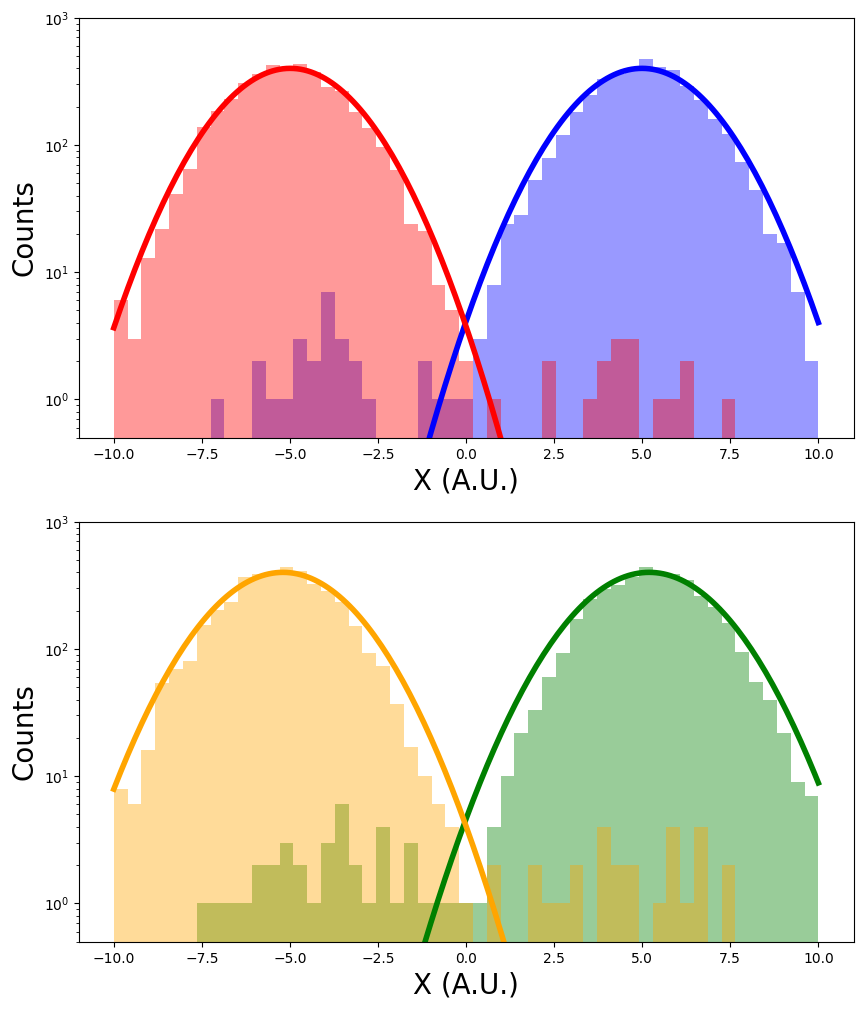

In [8]:
opt_fid_ind = np.argmax(big_fidelity[0])
norm_fid_ind = np.argmax(big_fidelity[-1])

opt_res_g = result_1[0, opt_fid_ind]
norm_res_g = result_1[0, norm_fid_ind]
opt_res_e = result_2[0, opt_fid_ind]
norm_res_e = result_2[0, norm_fid_ind]

total_mean_opt = 0.5 * (np.mean(opt_res_g) + np.mean(opt_res_e))
total_mean_norm = 0.5 * (np.mean(norm_res_g) + np.mean(norm_res_e))

opt_res_g -= total_mean_opt
opt_res_e -= total_mean_opt
norm_res_g -= total_mean_norm
norm_res_e -= total_mean_norm

angle_opt = 0.5 * (np.angle(np.mean(opt_res_g)) + np.angle(np.mean(opt_res_e))) - 0.5 * np.pi
angle_norm = 0.5 * (np.angle(np.mean(norm_res_g)) + np.angle(np.mean(norm_res_e))) - 0.5 * np.pi

opt_res_g *= np.exp(-1.0j * angle_opt)
opt_res_e *= np.exp(-1.0j * angle_opt)
norm_res_g *= np.exp(-1.0j * angle_norm)
norm_res_e *= np.exp(-1.0j * angle_norm)

real_opt_g = -opt_res_g.real
real_opt_e = -opt_res_e.real
real_norm_g = norm_res_g.real
real_norm_e = norm_res_e.real

real_axis_linspace = np.linspace(-10., 10., 201)

mean_opt_g = np.mean(real_opt_g)
std_opt_g = np.std(real_opt_g)
mean_opt_e = np.mean(real_opt_e)
std_opt_e = np.std(real_opt_e)
mean_norm_g = np.mean(real_norm_g)
std_norm_g = np.std(real_norm_g)
mean_norm_e = np.mean(real_norm_e)
std_norm_e = np.std(real_norm_e)

opt_g_fit = 400 * np.exp(-(real_axis_linspace - mean_opt_g)**2 / (2 * std_opt_g**2))
opt_e_fit = 400 * np.exp(-(real_axis_linspace - mean_opt_e)**2 / (2 * std_opt_e**2))

norm_g_fit = 400 * np.exp(-(real_axis_linspace - mean_norm_g)**2 / (2 * std_norm_g**2))
norm_e_fit = 400 * np.exp(-(real_axis_linspace - mean_norm_e)**2 / (2 * std_norm_e**2))

fig, ax = plt.subplots(2, figsize=(10., 12.0))

bins = 51
alpha = 0.4
linewidth = 4
fontsize = 20
range = (-10., 10.)

ax[0].hist(real_opt_g, range=range, bins=bins, color='blue', alpha=alpha)
ax[0].hist(real_opt_e, range=range, bins=bins, color='red', alpha=alpha)
ax[0].plot(real_axis_linspace, opt_g_fit, color='blue', linewidth=linewidth)
ax[0].plot(real_axis_linspace, opt_e_fit, color='red', linewidth=linewidth)
ax[0].set_yscale('log')
ax[0].set_ylim(0.5, 1000)
ax[0].set_xlabel('X (A.U.)', fontsize=fontsize)
ax[0].set_ylabel('Counts', fontsize=fontsize)

ax[1].hist(real_norm_g, range=range, bins=bins, color='green', alpha=alpha)
ax[1].hist(real_norm_e, range=range, bins=bins, color='orange', alpha=alpha)
ax[1].plot(real_axis_linspace, norm_g_fit, color='green', linewidth=linewidth)
ax[1].plot(real_axis_linspace, norm_e_fit, color='orange', linewidth=linewidth)
ax[1].set_yscale('log')
ax[1].set_ylim(0.5, 1000)
ax[1].set_xlabel('X (A.U.)', fontsize=fontsize)
ax[1].set_ylabel('Counts', fontsize=fontsize)

# plt.title('Histogram of Results')
plt.show()

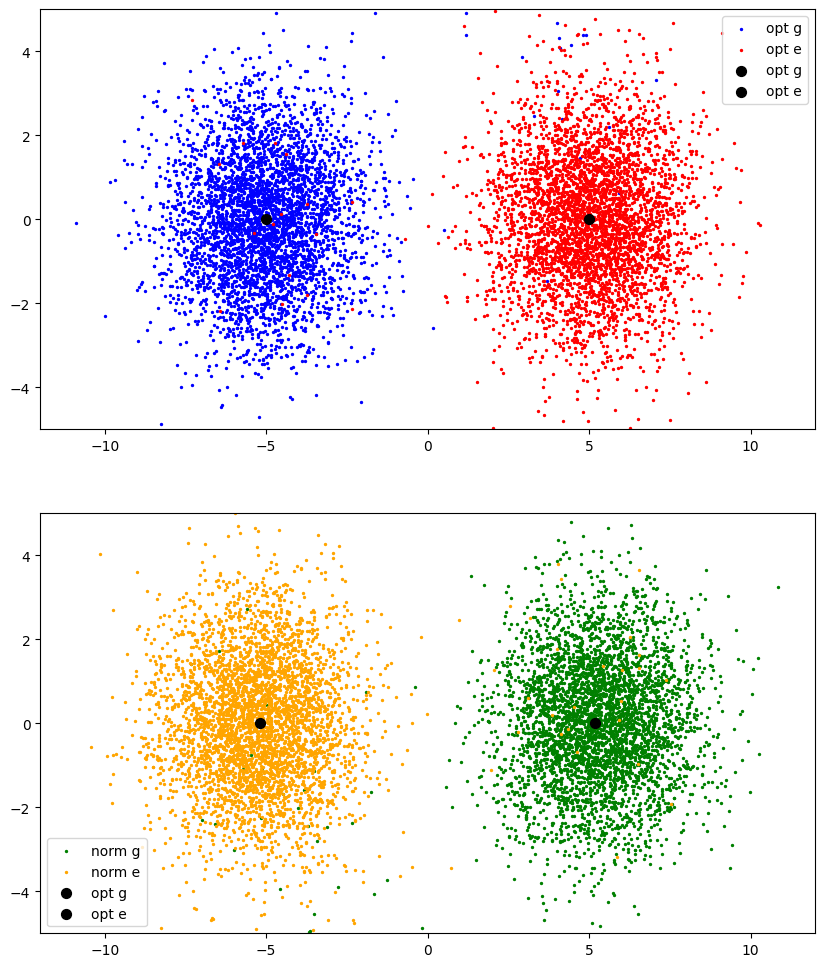

In [9]:
fig, ax = plt.subplots(2, figsize=(10.0, 12.0))

x_bounds = (-12., 12.)
y_bounds = (-5., 5.)
data_alpha = 1.0
data_size = 2
mean_alpha = 1.0
mean_size = 50

ax[0].scatter(
    opt_res_g.real, 
    opt_res_g.imag, 
    label='opt g',
    color='blue',
    alpha=data_alpha,
    s=data_size
)
ax[0].scatter(
    opt_res_e.real, 
    opt_res_e.imag, 
    label='opt e',
    color='red',
    alpha=data_alpha,
    s=data_size
)
ax[0].scatter(
    np.mean(opt_res_g).real, 
    np.mean(opt_res_g).imag, 
    label='opt g',
    color='black',
    alpha=mean_alpha,
    s=mean_size
)
ax[0].scatter(
    np.mean(opt_res_e).real, 
    np.mean(opt_res_e).imag, 
    label='opt e',
    color='black',
    alpha=mean_alpha,
    s=mean_size
)
ax[0].set_xlim(*x_bounds)
ax[0].set_ylim(*y_bounds)
ax[0].legend()

ax[1].scatter(
    norm_res_g.real, 
    norm_res_g.imag, 
    label='norm g',
    color='green',
    alpha=data_alpha,
    s=data_size
)
ax[1].scatter(
    norm_res_e.real, 
    norm_res_e.imag, 
    label='norm e',
    color='orange',
    alpha=data_alpha,
    s=data_size
)
ax[1].scatter(
    np.mean(norm_res_g).real, 
    np.mean(norm_res_g).imag, 
    label='opt g',
    color='black',
    alpha=mean_alpha,
    s=mean_size
)
ax[1].scatter(
    np.mean(norm_res_e).real, 
    np.mean(norm_res_e).imag, 
    label='opt e',
    color='black',
    alpha=mean_alpha,
    s=mean_size
)
ax[1].set_xlim(*x_bounds)
ax[1].set_ylim(*y_bounds)
ax[1].legend()
plt.legend()
plt.show()

[0.00549316 0.00683594 0.00646973]
[270.22222222 277.33333333 341.33333333]
[42.66666667 46.22222222]


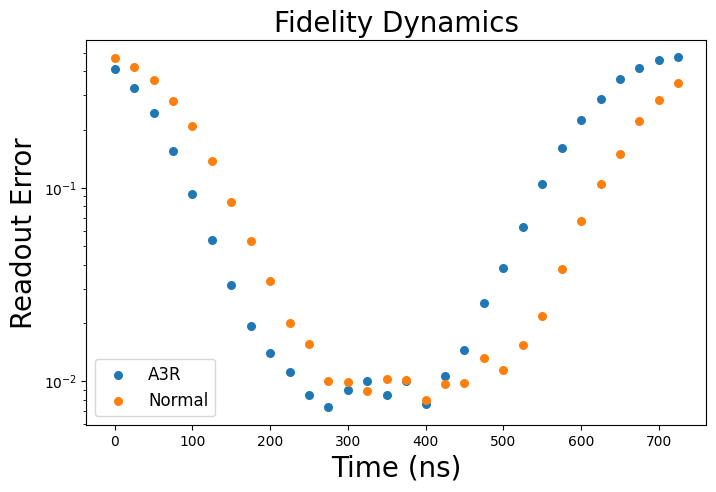

In [10]:
big_pf = -np.log10(1. - big_fidelity)
big_pf = 1. - big_fidelity
big_sep_pf = -np.log10(1. - big_sep_fidelity)
big_sep_pf = 1. - big_sep_fidelity

a_start = 0 * ns
a_end = 750 * ns
a_step = 25 * ns
plotting_linspace = np.arange(a_start, a_end, a_step) # + 0.5 * acq_duration_dt * dt
# print(plotting_linspace/ns)

opt_pf = np.interp(plotting_linspace, real_acq_linspace, big_pf[0])
opt_sep_pf = np.interp(plotting_linspace, real_acq_linspace, big_sep_pf[0])
norm_pf = np.interp(plotting_linspace, real_acq_linspace, big_pf[-1])
norm_sep_pf = np.interp(plotting_linspace, real_acq_linspace, big_sep_pf[-1])

print(np.min(big_pf, axis=-1))
print(real_acq_linspace[np.argmin(big_pf, axis=-1)]/ns)
print(real_tau_1_linspace/ns)

s = 30

plt.figure(figsize=(8., 5.))

plt.scatter(
    plotting_linspace/ns, 
    opt_pf, 
    label='A3R',
    s=s
)
# plt.plot(real_acq_linspace/ns, big_pf[0], label='full opt pF')
plt.scatter(
    plotting_linspace/ns, 
    norm_pf, 
    label='Normal',
    s=s
)
# plt.plot(real_acq_linspace/ns, big_pf[-1], label='full norm pF')
plt.yscale('log')
plt.xlabel('Time (ns)', fontsize=20)
plt.ylabel('Readout Error', fontsize=20)
plt.title('Fidelity Dynamics', fontsize=20)
plt.legend(fontsize=12)
plt.show()

[  0.  25.  50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325.
 350. 375. 400. 425. 450. 475. 500. 525. 550. 575. 600. 625. 650. 675.
 700. 725.]


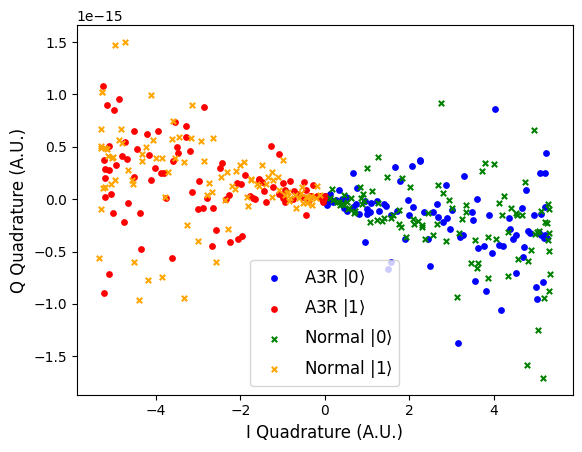

In [12]:
mean_g = np.mean(result_1, axis=-1)
mean_e = np.mean(result_2, axis=-1)

angle_dev = 0.5 * (np.angle(mean_g) + np.angle(mean_e)) - 0.5 * np.pi
# angle_dev = np.unwrap(angle_dev, period=2 * np.pi, axis=-1)

mean_g *= np.exp(-1.0j * angle_dev)
mean_e *= np.exp(-1.0j * angle_dev)

mean_g *= np.sign(mean_g.imag)
mean_e *= np.sign(mean_e.imag)

mean_g *= np.sign(mean_g.real)
mean_e *= -np.sign(mean_e.real)

opt_g = mean_g[0]
opt_e = mean_e[0]
norm_g = mean_g[-1]
norm_e = mean_e[-1]

a_start = 0 * ns
a_end = 750 * ns
a_step = 25 * ns
plotting_linspace = np.arange(a_start, a_end, a_step)
print(plotting_linspace/ns)

# opt_g = np.interp(plotting_linspace, real_acq_linspace, opt_g)
# opt_e = np.interp(plotting_linspace, real_acq_linspace, opt_e)
# norm_g = np.interp(plotting_linspace, real_acq_linspace, norm_g)
# norm_e = np.interp(plotting_linspace, real_acq_linspace, norm_e)

s = 15

plt.scatter(
    opt_g.real, 
    opt_g.imag, 
    label='A3R $|0\\rangle$', 
    s=s,
    color='blue',
    # marker='x'
    # fillstyle=None,
    # edgecolors='blue'
)
plt.scatter(
    opt_e.real, 
    opt_e.imag, 
    label='A3R $|1\\rangle$', 
    s=s,
    color='red',
    # marker='x'
    # facecolors=None,
    # edgecolors='red'
)
plt.scatter(
    norm_g.real, 
    norm_g.imag, 
    label='Normal $|0\\rangle$', 
    s=s,
    color='green',
    marker='x'
    # facecolors=None,
    # edgecolors='green'
)
plt.scatter(
    norm_e.real, 
    norm_e.imag, 
    label='Normal $|1\\rangle$', 
    s=s,
    color='orange',
    marker='x'
    # facecolors=None,
    # edgecolors='orange'
)
plt.xlabel('I Quadrature (A.U.)', fontsize=12)
plt.ylabel('Q Quadrature (A.U.)', fontsize=12)
# plt.title('IQ Trajectories', fontsize=20)
plt.legend(fontsize=12)
plt.show()